<a href="https://colab.research.google.com/github/mrtkp9993/QuantitaveFinanceExamplesPy/blob/main/06_ARX_and_ARCH_models_volalitility_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install arch

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch.unitroot import VarianceRatio
from arch.univariate import ARX
from arch import arch_model
import datetime as dt
from arch.__future__ import reindexing
from arch.univariate import GARCH
import sys
from tqdm.notebook import tqdm

In [3]:
data = yf.download("KCHOL.IS", period = "max", start = "2018-01-03")
data.drop(['Open',	'High',	'Low',	'Close', 'Volume'], axis=1, inplace=True)
data.rename(columns={'Adj Close':'Price'}, inplace=True)
data

[*********************100%***********************]  1 of 1 completed


,Price
Date,
2018-01-03,17.006323
2018-01-04,16.714993
2018-01-05,16.906178
2018-01-08,16.787825
2018-01-09,16.724096
...,...
2021-08-24,24.100000
2021-08-25,23.459999
2021-08-26,23.420000


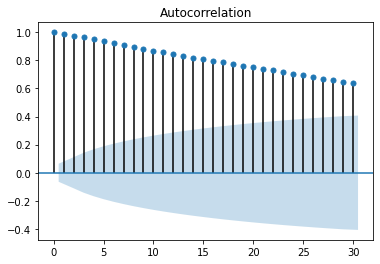

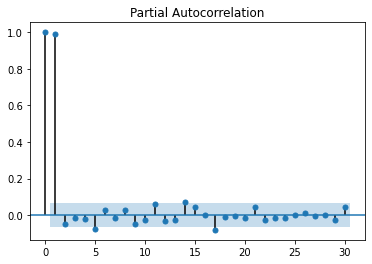

In [4]:
plot_acf(data)
plot_pacf(data)
plt.show()

In [5]:
VarianceRatio(data) # Price is unpredictable!!!

Test Statistic,0.273
P-value,0.785
Lags,2


In [6]:
# Calculate returns and squared returns
data['ret'] = np.log(data.Price) - np.log(data.Price.shift(1))
data['ret_sq'] =data['ret'] ** 2
data.dropna(inplace=True)

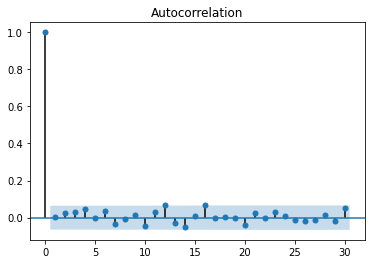

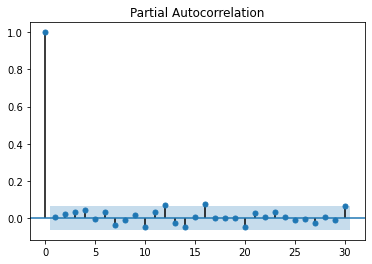

In [7]:
plot_acf(data['ret'])
plot_pacf(data['ret'])
plt.show()

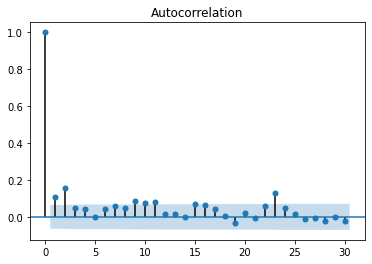

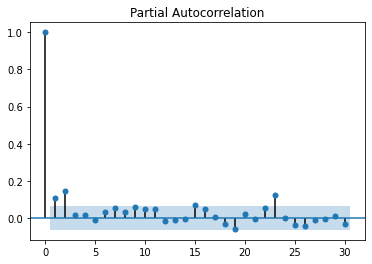

In [8]:
plot_acf(data['ret_sq'])
plot_pacf(data['ret_sq'])
plt.show()

In [9]:
# But, returns and squared returns are predictable!!
print(VarianceRatio(data['ret'])) 
print(VarianceRatio(data['ret_sq']))

     Variance-Ratio Test Results     
Test Statistic                 -8.493
P-value                         0.000
Lags                                2
-------------------------------------

Computed with overlapping blocks (de-biased)
     Variance-Ratio Test Results     
Test Statistic                 -2.349
P-value                         0.019
Lags                                2
-------------------------------------

Computed with overlapping blocks (de-biased)


In [10]:
returns_sq = 10000 * data['ret_sq']

                           AR - GARCH Model Results                           
Dep. Variable:                 ret_sq   R-squared:                      -0.241
Mean Model:                        AR   Adj. R-squared:                 -0.246
Vol Model:                      GARCH   Log-Likelihood:               -3143.98
Distribution:                  Normal   AIC:                           6301.97
Method:            Maximum Likelihood   BIC:                           6335.61
                                        No. Observations:                  903
Date:                Tue, Aug 31 2021   Df Residuals:                      899
Time:                        13:01:15   Df Model:                            4
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          1.3879      0.468      2.967  3.006e-03 

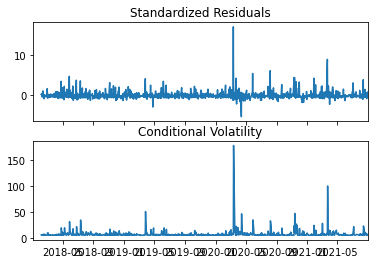

In [11]:
# AR - GARCH Model
ar_garch = ARX(returns_sq, lags=[1,5,22])
res_ar_garch = ar_garch.fit()
ar_garch.volatility = GARCH(p=1, q=1)
res_ar_garch = ar_garch.fit(update_freq=0, disp="off")

print(res_ar_garch.summary())
res_ar_garch.plot()
plt.show()

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                       ret_sq   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -2524.00
Distribution:      Standardized Student's t   AIC:                           5060.01
Method:                  Maximum Likelihood   BIC:                           5088.98
                                              No. Observations:                  925
Date:                      Tue, Aug 31 2021   Df Residuals:                      924
Time:                              13:01:15   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1

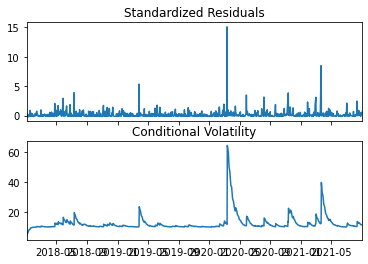

In [12]:
# GRJ-GARCH model
grja = arch_model(returns_sq, p = 1, q = 1, o = 1, vol = 'GARCH', dist = 't')
res_grja = grja.fit(disp = 'off')

print(res_grja.summary())
res_grja.plot()
plt.show()

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                       ret_sq   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -2525.33
Distribution:      Standardized Student's t   AIC:                           5062.66
Method:                  Maximum Likelihood   BIC:                           5091.64
                                              No. Observations:                  925
Date:                      Tue, Aug 31 2021   Df Residuals:                      924
Time:                              13:01:16   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1

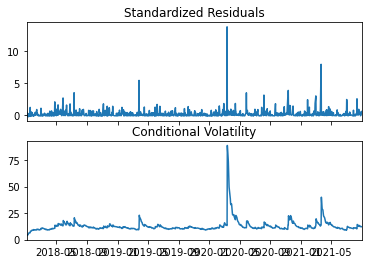

In [13]:
# E-GARCH model
egarch = arch_model(returns_sq, p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't')
res_egarch = egarch.fit(disp = 'off')

print(res_egarch.summary())
res_egarch.plot()
plt.show()

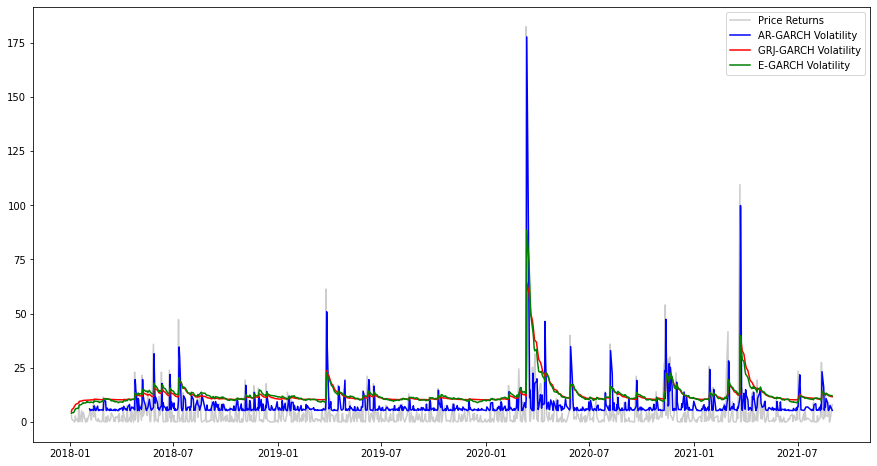

In [14]:
plt.figure(figsize=(15,8))
plt.plot(returns_sq, color = 'grey', alpha = 0.4, label = 'Price Returns')
plt.plot(res_ar_garch.conditional_volatility, color = 'blue', label = 'AR-GARCH Volatility')
plt.plot(res_grja.conditional_volatility, color = 'red', label = 'GRJ-GARCH Volatility')
plt.plot(res_egarch.conditional_volatility, color = 'green', label = 'E-GARCH Volatility')
plt.legend(loc = 'upper right')
plt.show()

In [15]:
print(f'AR-GARCH BIC: {res_ar_garch.bic}')
print(f'GJR-GARCH BIC: {res_grja.bic}')
print(f'EGARCH BIC: {res_egarch.bic}')

AR-GARCH BIC: 6335.6061782146235
GJR-GARCH BIC: 5088.984049330212
EGARCH BIC: 5091.640845402824


In [16]:
# Forecasting
# Rolling window
index = returns_sq.index
start_loc = 0
end_loc = np.where(index >= "2020-12-31")[0].min()
forecasts = {}
for i in tqdm(range(len(index)-end_loc+1)):
    res = grja.fit(first_obs=i, last_obs=i + end_loc, disp="off")
    temp = res.forecast(horizon=5, reindex=False).variance
    fcast = temp.iloc[0]
    forecasts[fcast.name] = fcast

res_rolling = pd.DataFrame(forecasts).T

# Recursive Rolling Window
forecasts = {}
for i in tqdm(range(len(index)-end_loc+1)):
    res = grja.fit(last_obs=i + end_loc, disp="off")
    temp = res.forecast(horizon=5, reindex=False).variance
    fcast = temp.iloc[0]
    forecasts[fcast.name] = fcast

res_rec = pd.DataFrame(forecasts).T

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

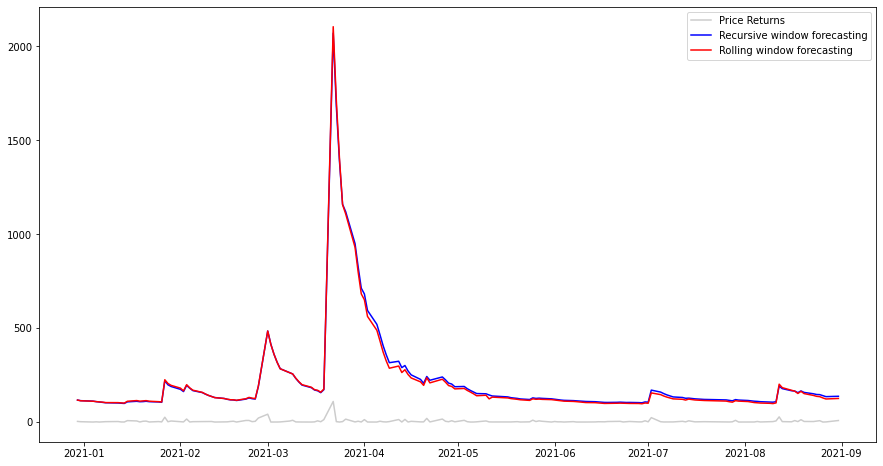

In [17]:
plt.figure(figsize=(15,8))
plt.plot(returns_sq.iloc[end_loc-1:], color = 'grey', alpha = 0.4, label = 'Price Returns')
plt.plot(res_rec['h.1'], color = 'blue', label = 'Recursive window forecasting')
plt.plot(res_rolling['h.1'], color = 'red', label = 'Rolling window forecasting')
plt.legend(loc = 'upper right')
plt.show()